<a href="https://colab.research.google.com/github/Militensire/Kohinoka_Project/blob/main/coffe_leave_disease_detector_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Preparation<b>

## <i>Import Library Dependencies<i>

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

#from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tqdm import tqdm
import numpy as np
from glob import glob

## <i>Mount Drive to Input Dataset<i>

Mount the drive which contain coffe leave rust and miner dataset.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/kohinoka/coffe_leave_disease.zip"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <i>Save the dataset to Colab<i>

Unzip the the dataset and save it under '/tmp' directory. /tmp folder can be seen at the file section on the left window. 

In [5]:
import os
import zipfile

local_zip = '/content/drive/My Drive/kohinoka/coffe_leafe_complete_dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

define the train and validation folder path using OS library

In [13]:
base_dir = '/tmp/coffe_leafe_complete_dataset'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_miner_dir = os.path.join(train_dir, 'miner')
train_rust_dir = os.path.join(train_dir, 'rust')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Directory with our validation cat/dog pictures
test_miner_dir = os.path.join(test_dir, 'predict')
# test_rust_dir = os.path.join(test_dir, 'rust')

## <i>Cheking the Dataset<i>

Several codes below could help you to see some parts of the dataset

In [15]:
train_miner_fnames = os.listdir( train_miner_dir )
train_rust_fnames = os.listdir( train_rust_dir )
train_healthy_fnames = os.listdir( train_healthy_dir )

print(train_miner_fnames[:10])
print(train_rust_fnames[:10])
print(train_healthy_fnames[:10])

['bicho_mineiro141.jpg', 'bicho_mineiro153.jpg', 'bicho_mineiro21.jpg', 'bicho_mineiro126.jpg', 'bicho_mineiro197.jpg', 'bicho_mineiro91.jpg', 'bicho_mineiro94.jpg', 'bicho_mineiro198.jpg', 'bicho_mineiro56.jpg', 'bicho_mineiro221.jpg']
['name41.jpg', 'name113.jpg', 'name248.jpg', 'name280.jpg', 'name273.jpg', 'name173.jpg', 'name267.jpg', 'name101.jpg', 'name199.jpg', 'name208.jpg']
['C3P5E1.jpg', 'C4P11H1.jpg', 'C2P23E1.jpg', 'C5P17E1.jpg', 'C2P1H2.jpg', 'C7P11H2.jpg', 'C6P34H2.jpg', 'C3P19E1.jpg', 'C11P6H1.jpg', 'C3P3E1.jpg']


In [16]:
print('total training miner images :', len(os.listdir(train_miner_dir ) ))
print('total training rust images :', len(os.listdir(train_rust_dir ) ))
print('total training healthy images :', len(os.listdir(train_healthy_dir ) ))

print('total test miner images :', len(os.listdir( test_miner_dir ) ))
# print('total validation rust images :', len(os.listdir( validation_rust_dir ) ))

total training miner images : 229
total training rust images : 256
total training healthy images : 252
total test miner images : 88


In [24]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 4

pic_index = 0 # Index for iterating over images

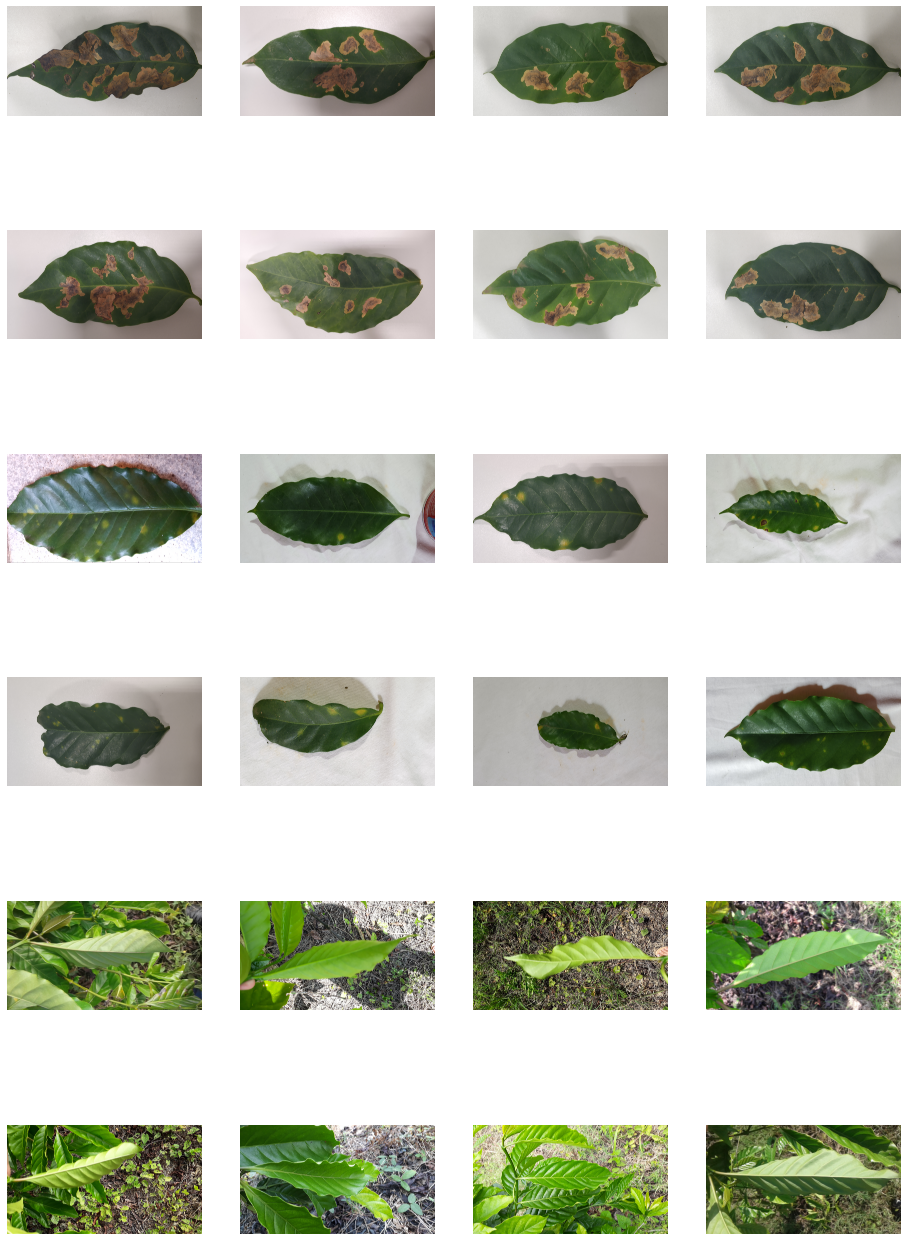

In [27]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_miner_pix = [os.path.join(train_miner_dir, fname) 
                for fname in train_miner_fnames[ pic_index-8:pic_index] 
               ]

next_rust_pix = [os.path.join(train_rust_dir, fname) 
                for fname in train_rust_fnames[ pic_index-8:pic_index]
               ]

next_healthy_pix = [os.path.join(train_healthy_dir, fname) 
                for fname in train_healthy_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_miner_pix+next_rust_pix+next_healthy_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# <b>Inception_V3 Model<b>

## <i>Model Preparation<i>

*   Load the TensorFlow Hub Feature Vector. Select which model will be used.



In [28]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE])

print("Using {} with input size {} and output dimension {}".format(handle_base, IMAGE_SIZE, FV_SIZE))

Using inception_v3 with input size (299, 299) and output dimension 2048


* Select if you want to do fine tuning

In [29]:
do_fine_tuning = False #@param {type:"boolean"}

if do_fine_tuning:
    feature_extractor.trainable = True    
else:
    feature_extractor.trainable = False

* Build the model

In [30]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


* Configure the model metrics

In [31]:
if do_fine_tuning:
    optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
else:
    optimizer = 'adam'
    # optimizer = 'rmsprop'
    
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## <i>Generate Train and Test Image<i>

* Generate Dataset for training, validation, and testing

In [32]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
batch_size = 23

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size= IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=batch_size,
        color_mode = 'rgb',
        subset='training',
        shuffle=True,
        class_mode='sparse')

valid_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size= IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=batch_size,
        color_mode = 'rgb',
        subset='validation',
        shuffle=True,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size= IMAGE_SIZE,
        color_mode="rgb",
        batch_size=1,
        class_mode=None,
        shuffle=False)


Found 591 images belonging to 3 classes.
Found 146 images belonging to 3 classes.
Found 88 images belonging to 1 classes.


In [34]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='sparse_categorical_crossentropy', factor=0.2, patience=3, min_lr=0.0001
# )
# early = tf.keras.callbacks.EarlyStopping(
#     monitor='sparse_categorical_crossentropy', patience=6, mode='auto'
# )

history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.n//train_generator.batch_size,
      epochs=5,
      validation_data=train_generator,
      validation_steps=valid_generator.n//valid_generator.batch_size,
      verbose=1,
      # callbacks=[reduce_lr,early]
      )

Epoch 1/5
25/25 [==============================] - 140s 4s/step - loss: 0.7715 - accuracy: 0.6459 - val_loss: 0.1886 - val_accuracy: 0.9638
Epoch 2/5
25/25 [==============================] - 99s 4s/step - loss: 0.1345 - accuracy: 0.9706 - val_loss: 0.1036 - val_accuracy: 0.9710
Epoch 3/5
25/25 [==============================] - 98s 4s/step - loss: 0.1046 - accuracy: 0.9725 - val_loss: 0.0551 - val_accuracy: 0.9928
Epoch 4/5
25/25 [==============================] - 99s 4s/step - loss: 0.0821 - accuracy: 0.9904 - val_loss: 0.0579 - val_accuracy: 0.9783
Epoch 5/5
25/25 [==============================] - 99s 4s/step - loss: 0.0635 - accuracy: 0.9764 - val_loss: 0.0686 - val_accuracy: 0.9710


## <i>Plotting Loss and Accuracy<i>

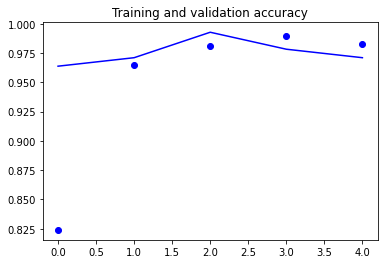

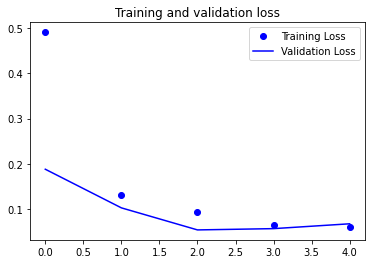

In [35]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* <i> See how the NN work <i>

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

NameError: ignored

## <i>Testing the Model<i>

<i> Evaluate loss and accuracy of the model<i>

In [36]:
score = model.evaluate(valid_generator)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

7/7 [==============================] - 19s 3s/step - loss: 0.0990 - accuracy: 0.9658


<i> Passing test_generator to the model<i>

In [46]:
pred = model.predict(test_generator) 
pred_healthy = np.argmax(pred, axis = 1)[:31]
pred_miner = np.argmax(pred, axis = 1)[31:59] 
pred_rust = np.argmax(pred, axis = 1)[59:88]

# Predict test data for healthy leafe
print(pred_healthy)
print(len(pred_healthy))
# Predict test data for miner leafe
print(pred_miner)
print(len(pred_miner))
# Predict test data for rust leafe
print(pred_rust) 
print(len(pred_rust))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
28
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
29


In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis = 1)[:] 
  print(fn)
  print(classes)

# MODEL DEPLOYMENT

In [ ]:
CLDD_SAVED_MODEL = "cldd_saved_model"

##Export The Saved Model

In [ ]:
tf.saved_model.save(model, CLDD_SAVED_MODEL)

INFO:tensorflow:Assets written to: cldd_saved_model/assets


INFO:tensorflow:Assets written to: cldd_saved_model/assets


In [ ]:
%%bash -s $CLDD_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 299, 299, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(CLDD_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


## Convert  Using TFLite's Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(CLDD_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_dir.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

AttributeError: ignored

## Utility functions for plotting

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()